In [7]:
import numpy as np
import pandas as pd
from collections import Counter
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import re

class Word2Vec:
    def __init__(self, window_size, embedding_size, learning_rate, epochs, negative_samples, random_state=None):
        self.window_size = window_size
        self.embedding_size = embedding_size
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.negative_samples = negative_samples
        self.word2id = {}
        self.id2word = {}
        self.vocab_size = 0
        self.random_state = random_state

    #Tokenizes the given corpus into sentences and words
    def tokenize_corpus(self, corpus):
        tokens = []
        for sentence in corpus:
            sentence = sentence.lower()  # Convert to lowercase
            sentence = re.sub(r"[,.?]", "", sentence)  # Remove commas and full stops
            tokens.append(sentence.split())
        return tokens

    #Counts the occurrence of each word in the given tokens
    def count_words(self, tokens):
        word_counts = Counter()
        for sentence in tokens:
            word_counts.update(sentence)
        return word_counts

    #Creates word-to-id and id-to-word mappings for the vocabulary
    def create_vocabularies(self, word_counts):
        vocab = {word: i for i, word in enumerate(word_counts)}
        inv_vocab = {i: word for word, i in vocab.items()}
        return vocab, inv_vocab

    #Generate training data from the given tokens and vocabulary
    def generate_training_data(self, tokens, vocab):
        training_data = []
        for sentence in tokens:
            for center_word_pos in range(len(sentence)):
                center_word = sentence[center_word_pos]
                context_words = sentence[max(0, center_word_pos - self.window_size):center_word_pos] + \
                                sentence[center_word_pos + 1:center_word_pos + self.window_size + 1]
                for context_word in context_words:
                    training_data.append((center_word, context_word))
        return training_data

    #Generate training data for the Skip-gram model
    def generate_skip_gram_training_data(self, tokens, vocab):
        training_data = []
        for sentence in tokens:
            for center_word_pos in range(len(sentence)):
                center_word = sentence[center_word_pos]
                context_words = sentence[max(0, center_word_pos - self.window_size):center_word_pos] + \
                                sentence[center_word_pos + 1:center_word_pos + self.window_size + 1]
                for context_word in context_words:
                    training_data.append((context_word, center_word))
        return training_data

    #Initialize word vectors with random values between -1 and 1
    def initialize_word_vectors(self, vocab_size): 
        self.vocab_size = vocab_size
        self.word_vectors = np.random.uniform(-1, 1, (vocab_size, self.embedding_size))

    #Trains the Word2Vec model using the given training data
    def train(self, training_data):
        for epoch in range(self.epochs):
            total_loss = 0
            np.random.shuffle(training_data)

            for target_word, context_word in training_data:
                target_word_idx = self.word2id[target_word]
                context_word_idx = self.word2id[context_word]

                # Positive example
                target_vec = self.word_vectors[target_word_idx]
                context_vec = self.word_vectors[context_word_idx]

                # Calculate dot product
                dot_product = np.dot(target_vec, context_vec)

                # Sigmoid activation
                sigmoid = 1 / (1 + np.exp(-dot_product))

                # Calculate loss
                loss = -np.log(sigmoid)
                total_loss += loss

                # Gradient calculation
                grad = (sigmoid - 1) * self.learning_rate

                # Update word vectors
                self.word_vectors[target_word_idx] -= grad * context_vec
                self.word_vectors[context_word_idx] -= grad * target_vec

                # Negative sampling
                negative_samples_idx = np.random.choice(self.vocab_size, self.negative_samples, replace=False)
                for neg_idx in negative_samples_idx:
                    neg_word_vec = self.word_vectors[neg_idx]
                    neg_dot_product = np.dot(target_vec, neg_word_vec)
                    neg_sigmoid = 1 / (1 + np.exp(-neg_dot_product))
                    neg_grad = neg_sigmoid * self.learning_rate
                    self.word_vectors[target_word_idx] -= neg_grad * neg_word_vec

            avg_loss = total_loss / len(training_data)
            print(f"Epoch: {epoch + 1} Loss: {avg_loss}")

    #Fits the Word2Vec model to the given corpus
    def fit(self, corpus, skip_gram=False):
        tokens = self.tokenize_corpus(corpus)
        word_counts = self.count_words(tokens)
        self.word2id, self.id2word = self.create_vocabularies(word_counts)
        if skip_gram:
            training_data = self.generate_skip_gram_training_data(tokens, self.word2id)
        else:
            training_data = self.generate_training_data(tokens, self.word2id)
        vocab_size = len(self.word2id)
        self.initialize_word_vectors(vocab_size)
        self.train(training_data)

    def get_word_vector(self, word):
        if word in self.word2id:
            word_id = self.word2id[word]
            return self.word_vectors[word_id]
        else:
            return None

    #Creates a pandas DataFrame from the word vectors
    def create_word_vector_dataframe(self):
        df = pd.DataFrame(self.word_vectors, index=[self.id2word[i] for i in range(self.vocab_size)])
        return df

    #Visualizes word embeddings using PCA
    def visualize_embeddings(self):
        pca = PCA(n_components=2)
        embeddings_pca = pca.fit_transform(self.word_vectors)

        plt.figure(figsize=(10, 10))
        for i, word in self.id2word.items():
            x, y = embeddings_pca[i]
            plt.scatter(x, y)
            plt.annotate(word, (x, y), alpha=0.8)

        plt.show()



In [8]:
np.random.seed(0)

corpus = [
    """You may write me down in history
With your bitter, twisted lies,
You may trod me in the very dirt
But still, like dust, I'll rise.

Does my sassiness upset you?
Why are you beset with gloom?
’Cause I walk like I've got oil wells
Pumping in my living room.

Just like moons and like suns,
With the certainty of tides,
Just like hopes springing high,
Still I'll rise.

Did you want to see me broken?
Bowed head and lowered eyes?
Shoulders falling down like teardrops,
Weakened by my soulful cries?

Does my haughtiness offend you?
Don't you take it awful hard
’Cause I laugh like I've got gold mines
Diggin’ in my own backyard.

You may shoot me with your words,
You may cut me with your eyes,
You may kill me with your hatefulness,
But still, like air, I’ll rise.

Does my sexiness upset you?
Does it come as a surprise
That I dance like I've got diamonds
At the meeting of my thighs?

Out of the huts of history’s shame
I rise
Up from a past that’s rooted in pain
I rise
I'm a black ocean, leaping and wide,
Welling and swelling I bear in the tide.

Leaving behind nights of terror and fear
I rise
Into a daybreak that’s wondrously clear
I rise
Bringing the gifts that my ancestors gave,
I am the dream and the hope of the slave.
I rise
I rise
I rise."""

]

window_size = 2
embedding_size = 50
learning_rate = 0.01
epochs = 250
negative_samples = 3
random_state = 147

model = Word2Vec(window_size, embedding_size, learning_rate,epochs, negative_samples, random_state)
#model.fit(corpus)
model.fit(corpus, skip_gram=True)

Epoch: 1 Loss: 1.1413721584556435
Epoch: 2 Loss: 0.8199665654750137
Epoch: 3 Loss: 0.6296310932781176
Epoch: 4 Loss: 0.516804784728296
Epoch: 5 Loss: 0.43875347814574267
Epoch: 6 Loss: 0.3813628098639541
Epoch: 7 Loss: 0.3373396996721131
Epoch: 8 Loss: 0.3049482607714927
Epoch: 9 Loss: 0.2804738740064734
Epoch: 10 Loss: 0.2625041768203867
Epoch: 11 Loss: 0.2470484570088744
Epoch: 12 Loss: 0.23506156986040028
Epoch: 13 Loss: 0.22344788076874475
Epoch: 14 Loss: 0.2154132997719585
Epoch: 15 Loss: 0.2083721715419261
Epoch: 16 Loss: 0.20234812940278418
Epoch: 17 Loss: 0.20012492966497508
Epoch: 18 Loss: 0.19663515775478718
Epoch: 19 Loss: 0.19243176581962082
Epoch: 20 Loss: 0.19081463611001712
Epoch: 21 Loss: 0.18716880908602732
Epoch: 22 Loss: 0.18556841135822194
Epoch: 23 Loss: 0.18171362687431702
Epoch: 24 Loss: 0.17854037945276768
Epoch: 25 Loss: 0.17716085578039706
Epoch: 26 Loss: 0.1786016282446566
Epoch: 27 Loss: 0.17662007932860538
Epoch: 28 Loss: 0.17591023221797683
Epoch: 29 Loss:

In [9]:
#Show some word vector
word_vector = model.get_word_vector('sexiness')
print(word_vector)

[ 0.00888687 -0.41893801 -0.25022507  0.72607183  0.23635917  0.11706135
 -0.5022339  -0.01970615  0.01164052 -0.20477139 -0.41506192  0.48309287
  0.10685422  0.56409739  0.1867757  -0.23848911  0.29343392  0.02827735
  0.10713406  0.24592405 -0.06669404 -0.42813599  0.30853615 -0.16437648
  0.28212837  0.08946471  0.69582959 -0.24483042  0.41679196 -0.28632503
 -0.67711633  0.37794686 -0.48163009  0.34517769 -0.29083288 -0.55580281
 -0.14449586  0.4344685  -0.32389674  0.36432064 -0.43310793  0.71368686
  0.17273053  0.64253715 -0.43893968  0.50604802  0.56891543 -0.08079391
 -0.04155707 -0.39027601]


In [10]:
# Create DataFrame for word vectors
df_word_vectors = model.create_word_vector_dataframe()

# Display the DataFrame as a table
display(df_word_vectors)

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
you,-0.376470,-0.251096,-0.125261,0.339145,-0.213047,-0.305679,-0.012605,-0.240563,-0.073685,0.064762,...,-0.355986,0.319790,-0.097074,0.296368,-0.233081,0.345922,-0.066717,-0.251126,-0.140571,-0.499844
may,-0.390600,-0.162601,-0.757824,0.216828,-0.344704,-0.326916,0.230723,-0.097842,-0.225046,-0.039642,...,0.045688,-0.174601,-0.182155,0.181011,-0.253931,0.152150,-0.519596,-0.146362,0.024614,-0.575619
write,-0.149523,-0.185246,-0.265527,0.750902,-0.983050,-0.405701,0.101413,0.068561,-0.622894,0.464794,...,0.283073,-0.366662,-0.065036,0.567878,0.207704,0.046891,-0.613793,-0.102678,0.204276,0.421688
me,-0.437874,0.118302,-0.834136,0.334377,-0.388717,-0.234442,0.197685,0.027517,-0.260963,-0.271837,...,-0.058344,-0.474354,0.034348,-0.108506,-0.393939,-0.456948,-0.366943,-0.037057,0.081119,-0.332899
down,0.030748,0.077895,-0.145424,0.443485,-0.652927,-0.513401,0.374525,0.211642,-0.166070,-0.058568,...,0.004734,-0.531004,0.018429,0.054834,0.327144,-0.504629,0.264774,-0.382234,-0.300059,0.549608
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
gave,-0.126308,0.195463,0.255197,-0.136046,0.104001,-0.001561,-0.636502,0.274322,0.413377,-0.259872,...,-0.153605,0.226569,-0.312527,-0.880897,0.222518,-0.030318,0.359959,0.042405,0.146786,-0.141757
am,-0.311328,0.154970,0.620603,0.071244,0.194246,0.046430,-0.636912,0.156917,0.361898,0.126222,...,-0.018224,-0.710597,-0.133618,-0.933877,0.284961,-0.258400,0.812074,-0.777363,0.739128,0.099709
dream,-0.474123,0.355781,-0.091553,-0.026775,0.009386,0.198705,-0.048195,0.498351,-0.104916,-0.086551,...,-0.168032,-0.882558,0.195295,-0.287651,0.346790,-0.136115,0.629366,-0.188187,0.069560,-0.086021
hope,0.275245,0.007048,0.407508,-0.042776,0.012345,0.224621,-0.263213,0.103668,-0.437808,0.096906,...,0.718817,-0.886278,-0.026527,0.031481,0.349376,-0.079982,0.380127,-0.105092,-0.293911,-0.040159


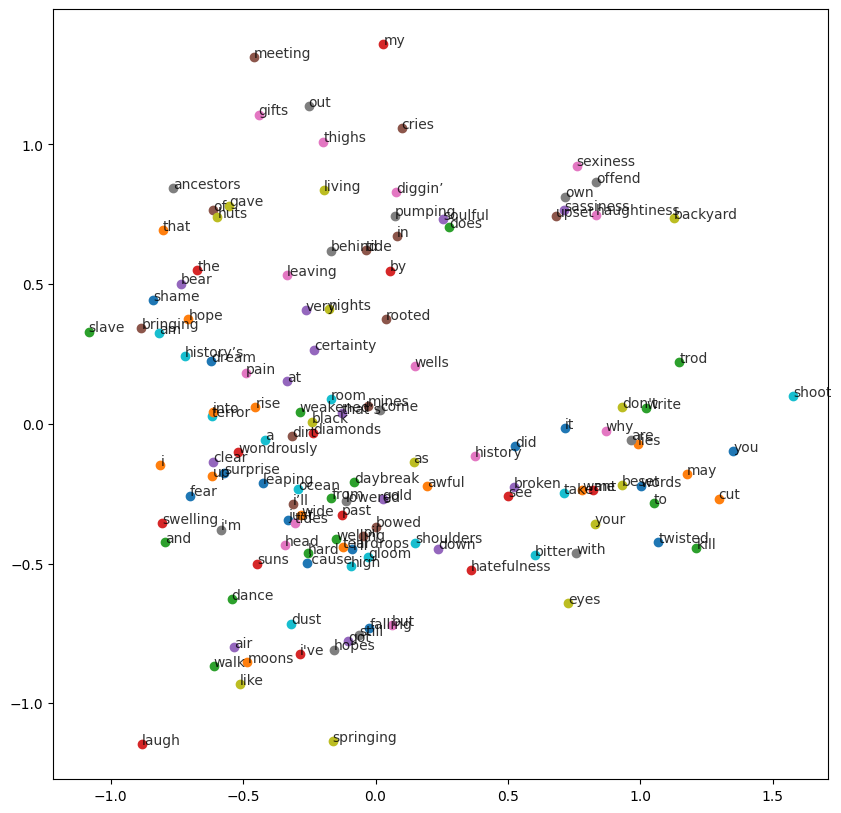

In [11]:
model.visualize_embeddings()

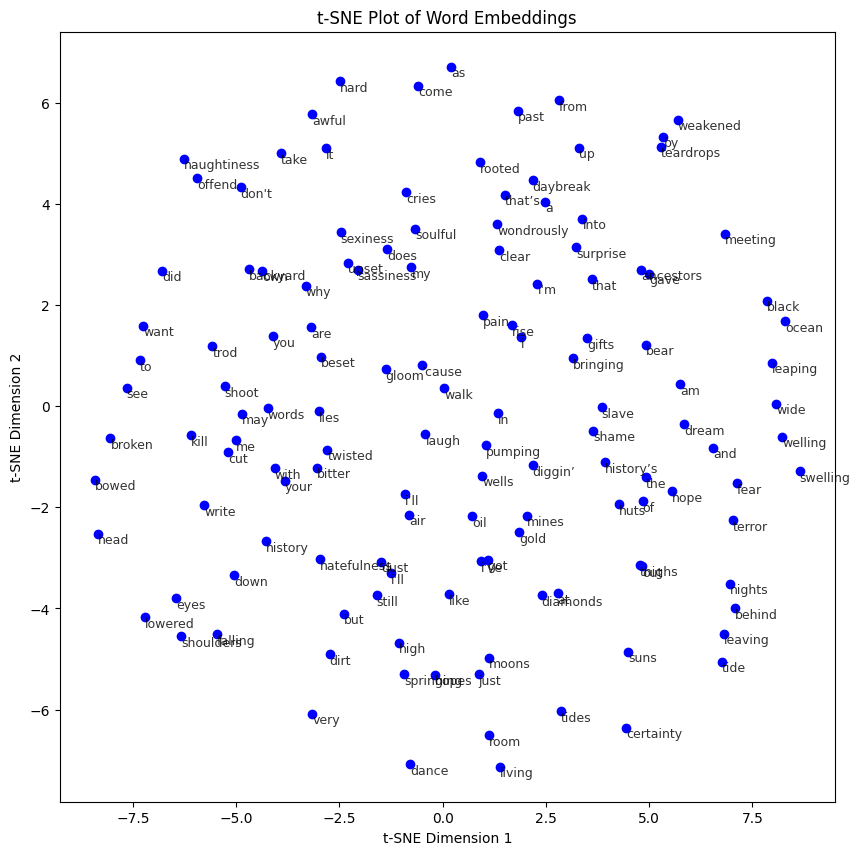

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Assuming you already have the DataFrame df_word_vectors containing the word vectors

# Perform dimensionality reduction using t-SNE
tsne = TSNE(n_components=2, random_state=147)
tsne_result = tsne.fit_transform(df_word_vectors)

# Create a new DataFrame for the reduced dimensions
df_tsne = pd.DataFrame(tsne_result, index=df_word_vectors.index, columns=['x', 'y'])

# Plot the t-SNE result
plt.figure(figsize=(10, 10))
plt.scatter(df_tsne['x'], df_tsne['y'], color='blue')

# Add labels to the points
for i, (word, (x, y)) in enumerate(df_tsne.iterrows()):
    plt.text(x, y, word, fontsize=9, ha='left', va='top', alpha=0.8)

plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.title('t-SNE Plot of Word Embeddings')
plt.show()
